In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Dependent variable (EPC rating)

In [51]:
df = pd.read_csv("/content/drive/MyDrive/WMCA/EPC_elec_consump_fuel_poverty.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (24,68) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


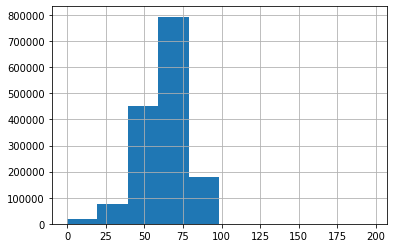

In [52]:
df["current-energy-efficiency"].hist()
plt.show()

In [53]:
# Energy efficiency ratings should only go up to 100
df = df[df["current-energy-efficiency"] <=100]
print(f"Min: {df['current-energy-efficiency'].min()}")
print(f"Max: {df['current-energy-efficiency'].max()}")

Min: 0
Max: 100


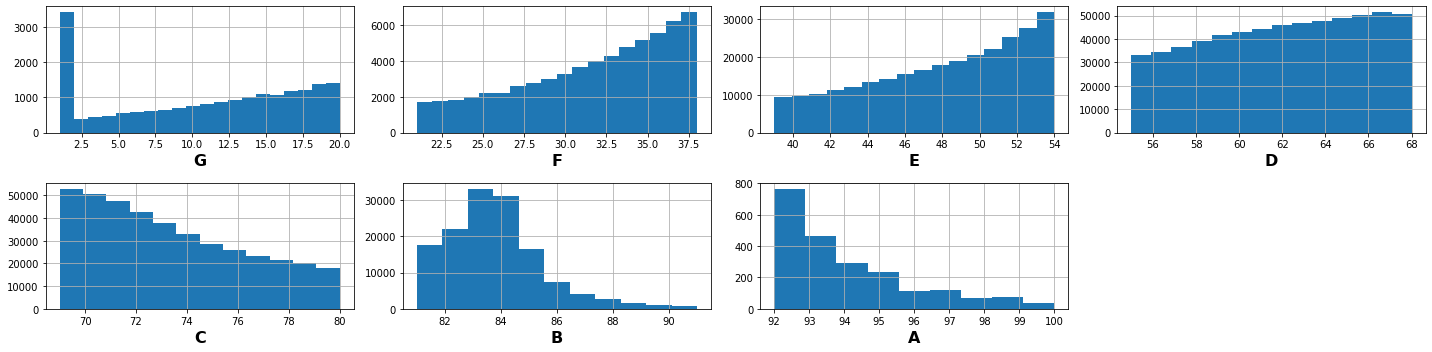

In [54]:
plt.figure(figsize=(20,5))

bands = ['G', 'F', 'E', 'D', 'C', 'B','A']

for i, band in enumerate(bands):
  epc_bands = df[df["current-energy-rating"] == band]
  plt.subplot(241+i)
  bins = len(epc_bands['current-energy-efficiency'].unique())
  epc_bands['current-energy-efficiency'].hist(bins=bins)
  plt.xlabel(band,fontsize=16, weight='bold')

plt.tight_layout()

# Impute missing values

For values which do not change often over time such as `built-form` (detached, terraced etc), it's safe to use the data from previous certificates where available to fill the missing values in more recent certificates.


In [55]:
epc_grouped = df.groupby(['uprn'], as_index=False)['inspection-date'].count()
epc_grouped_2plus = epc_grouped[epc_grouped['inspection-date'] > 1]
epc_2plus = df.merge(epc_grouped_2plus[['uprn']], on = 'uprn', how = 'inner')

In [56]:
# note this takes a while
fill_columns = ['built-form', 'floor-level','number-habitable-rooms','floor-description',
                'roof-description','heat-loss-corridor','walls-description','floor-height',
                'mains-gas-flag']

for c in fill_columns:
    print(c)
    epc_2plus[c] = epc_2plus.groupby(['uprn'], sort=False)[c].apply(lambda x: x.ffill())

built-form
floor-level
number-habitable-rooms
floor-description
roof-description
heat-loss-corridor
walls-description
floor-height
mains-gas-flag


In [57]:
epc_grouped_1 = epc_grouped[epc_grouped['inspection-date'] == 1]
epc_1 = df.merge(epc_grouped_1[['uprn']], on = 'uprn', how = 'inner')

In [58]:
# merging filled data for buildings with more than one certificate with data for buildings with only one certificate
epc_filled = pd.concat([epc_1,epc_2plus])

In [59]:
# checking length of filled data (should be the)
print(f"Missing rows: {len(df) - len(epc_filled)}")
print(f"Property without UPRN: {len(df[df.uprn.isna()])}")

Missing rows: 19843
Property without UPRN: 19843


In [60]:
# remove rows without UPRN, doesn't exist and cannot find data
df = df[df.uprn.isna()==False]

# Standardising missing data labels

In [61]:
# replace 'NO DATA!', 'not defined' and 'not recored' with null
df = df.replace(['NO DATA!','NODATA!'],np.nan)
df = df.replace(['not recorded','not defined','unknown','Unknown','Not defined','Not recorded'],np.nan)
df = df.replace(['N/A','n/a'],np.nan)
df = df.replace(['INVALID!'],np.nan)

# Data Audit
This script takes an audit of the EPC data for WMCA. It looks at how many missing values each feature has, how many unique values the categorical features have then applies preprocessing steps to remove outliers and drop features with too many missing values. Note that [Sonia Williams](https://datasciencecampus.ons.gov.uk/projects/using-machine-learning-to-predict-energy-efficiency/) split the data into test and training before performing the following.

## Missing values

In [62]:
percent_missing = df.isnull().sum() * 100 / len(df)

In [63]:
percent_missing.sort_values(ascending=False)[:30]

ladnmw                          100.000000
sheating-env-eff                100.000000
sheating-energy-eff             100.000000
doterm                           99.435365
flat-storey-count                93.816274
address3                         93.733282
floor-env-eff                    92.877910
floor-energy-eff                 92.877910
unheated-corridor-length         87.812228
county                           78.869139
heat-loss-corridor               77.144027
flat-top-storey                  76.457578
floor-level                      74.356733
address2                         60.969930
low-energy-fixed-light-count     59.748313
floor-height                     59.745774
fixed-lighting-outlets-count     52.978435
photo-supply                     42.745170
solar-water-heating-flag         38.684005
main-heating-controls            17.834660
roof-env-eff                     14.911519
roof-energy-eff                  14.911519
glazed-type                      13.069538
mains-gas-f

Maybe we can map values from `photo-supply` to `solar-water-heating-flag`.

In [64]:
df.drop([
        # Remove variables with too many missing variables
        'sheating-env-eff', 'sheating-energy-eff', 'flat-storey-count', 
        'floor-env-eff', 'floor-energy-eff', 'unheated-corridor-length', 
        'county', 'heat-loss-corridor', 'flat-top-storey', 
        # Remove unnecessary variables
        'oa11cd', 'lsoa11cd', 'msoa11cd', 'lsoa11nm', 'msoa11nm', 
        'local-authority-label',
        # Remove variables with high % missing and similar variables
        'low-energy-fixed-light-count', 'fixed-lighting-outlets-count'
        ],
        axis = 1,
        inplace = True)


## Data sanity check

In [65]:
# Convert to datetime object
df['inspection-date'] = df['inspection-date'].astype('datetime64')
df['lodgement-datetime'] = df['lodgement-datetime'].astype('datetime64')

## remove similar column
df.drop(columns=['lodgement-date'], inplace=True)

In [66]:
# All valid years
df['inspection-date'].dt.year.value_counts(normalize=True)

2014    1.119294e-01
2013    1.039350e-01
2009    9.147828e-02
2015    8.521450e-02
2016    7.397926e-02
2010    7.127302e-02
2019    6.309483e-02
2018    6.302734e-02
2011    6.207648e-02
2021    6.179717e-02
2012    6.139625e-02
2020    5.863120e-02
2017    5.057062e-02
2008    2.569926e-02
2022    1.572827e-02
2007    1.503467e-04
2006    1.536877e-05
2004    2.004623e-06
2003    6.682076e-07
2005    6.682076e-07
Name: inspection-date, dtype: float64

In [67]:
# All valid years
df['lodgement-datetime'].dt.year.value_counts(normalize=True)

2014    0.111267
2013    0.103213
2009    0.091979
2015    0.086189
2016    0.074377
2010    0.071412
2019    0.064448
2021    0.062151
2011    0.062119
2018    0.062006
2012    0.061186
2020    0.058652
2017    0.049743
2008    0.024680
2022    0.016578
Name: lodgement-datetime, dtype: float64

## Clip values in numeric columns that are too high or negative

In [68]:
num_var = df.select_dtypes(include= 'number').columns.tolist()

# Not these variables
num_var.remove('uprn')
num_var.remove('LATITUDE')
num_var.remove('LONGITUDE')

In [69]:
audit_num = df[num_var].describe(percentiles = [0.25,0.5,0.75,0.9,0.95,0.99])

In [70]:
# Clips the variables of the EPC data between 0 and the upper bound of the 99% confidence interval
for var in num_var:
  df[var].clip(lower=0.0, upper=audit_num[var]['99%'], inplace=True)

## Reduce levels in categorical fields
We will need to group categories for those with many levels using CHAID and other methods in the next notebook.

In [71]:
cat_var = df.select_dtypes(include= ['object','category']).columns.tolist()

# Not these variables
cat_var.remove('lmk-key')
cat_var.remove('address')
cat_var.remove('postcode')

In [72]:
df[cat_var].nunique().sort_values(ascending = False)[:30]

address1                    1000032
address2                      35279
address3                       5827
posttown                        925
walls-description               758
floor-description               497
roof-description                390
mainheat-description            269
lighting-description            222
main-heating-controls           114
hotwater-description            112
mainheatcont-description         69
constituency                     69
constituency-label               69
floor-level                      53
secondheat-description           49
windows-description              48
main-fuel                        45
local-authority                  43
construction-age-band            34
transaction-type                 18
ladcd                            17
ladnm                            17
energy-tariff                     9
glazed-type                       8
current-energy-rating             7
potential-energy-rating           7
tenure                      

### Standardising entries

Currently assuming we won't have Welsh in the final dataset. Thought: Maybe some kind of topic modeller might also help standardise entries.

In [73]:
for c in ['floor-description','walls-description','roof-description']:
    # standardising the unit used
    df[c] = df[c].str.replace(r"W(.*?)K",'W/m²K')
    # removing nonsense 
    df[c] = df[c].str.replace("\*\*\* INVALID INPUT Code \: 57 \*\*\*","")
    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """


In [74]:
df['transaction-type'] = df['transaction-type'].str.replace(" - this is for backwards compatibility only and should not be used","")
df['transaction-type'] = df['transaction-type'].str.replace("Stock Condition Survey", "Stock condition survey")

In [78]:
df['mainheatcont-description'] = df['mainheatcont-description'].str.replace(" communit ", " community ")
df['mainheatcont-description'] = df['mainheatcont-description'].str.replace(" prog ", " programmer ")

In [77]:
for entry in df['mainheat-description'].unique():
  print(entry)

Warm air, Electricaire
Room heaters, electric
Electric storage heaters
Electric underfloor heating
Community scheme
Air source heat pump, warm air, electric
Warm air, electric
Ground source heat pump, warm air, electric
Warm air, mains gas
No system present: electric heaters assumed
Water source heat pump, warm air, electric
Boiler and radiators, mains gas
SAP05:Main-Heating
Room heaters, electricity
Room heaters, mains gas
Boiler and underfloor heating, electric
Boiler and underfloor heating, mains gas
Boiler and radiators, electric
Electric ceiling heating
Portable electric heaters assumed for most rooms
Warm air, mains gas, Boiler and radiators, mains gas
Fully double glazed, warm air, electric
Ground source heat pump, radiators, electric
Electric storage heaters, Room heaters, electric
Warm air, oil
Air source heat pump, radiators, electric
Boiler and radiators, LPG
Portable electric heating assumed for most rooms
Community scheme, mains gas
Boiler and radiators, smokeless fuel
Com

In [79]:
df.to_csv("/content/drive/MyDrive/WMCA/data_cleaning.csv", index=False)